In [1]:
import os
# Disable GPU for tensorflow
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

from scipy.stats import chi2_contingency, randint, uniform
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn import preprocessing
from joblib import dump

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

2024-06-19 10:37:45.419466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Supress warnings
warnings.filterwarnings("ignore")

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

# Safe Driving Dataset

In [5]:
# Define the database parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group17',
    'password': 'blockd_2024group17_61'
}


In [6]:
# Connect to the database
conn = psycopg2.connect(**db_params)

cursor = conn.cursor()

# Query the database
query = """SELECT * FROM data_lake.safe_driving"""

# Load the data into a DataFrame
df = pd.read_sql_query(query, conn)

In [7]:
# Filter DataFrame to only include valid data
df = df[df['is_valid'] == True]

In [8]:
# Extract the numeric part of the incident_severity column
df['incident_severity'] = df['incident_severity'].str.extract('(\d+)')

# Convert the extracted string to a number
df['incident_severity'] = pd.to_numeric(df['incident_severity'])

In [9]:
# Convert columns to datetime
df['date'] = df['event_start'].dt.date
df['year'] = df['event_start'].dt.year
df['month'] = df['event_start'].dt.month
df['day'] = df['event_start'].dt.day
df['month_day'] = df['event_start'].dt.strftime('%m-%d')

# Strip whitespace from the category column
df['category'] = df['category'].str.strip()

In [10]:
# Group by 'road_name' and 'year', and calculate the total number of occurrences
yearly_counts = df.groupby(['road_name', 'year']).size().reset_index(name='yearly_occurrences')

# Group by 'road_name' and calculate the average number of occurrences per year
average_yearly_counts = yearly_counts.groupby('road_name')['yearly_occurrences'].mean().reset_index(name='average_yearly_occurrences')

In [11]:
# Group by 'road_name' and 'year', and calculate the total number of occurrences
monthly_counts = df.groupby(['road_name', 'month']).size().reset_index(name='monthly_occurrences')

# Group by 'road_name' and calculate the average number of occurrences per year
average_monthly_counts = monthly_counts.groupby('road_name')['monthly_occurrences'].mean().reset_index(name='average_monthly_occurrences')

In [12]:
# Group by 'road_name' and 'year', and calculate the total number of occurrences
month_day_counts2 = df.groupby(['road_name', 'month_day']).size().reset_index(name='month_day_occurrences')

# Group by 'road_name' and calculate the average number of occurrences per year
average_month_day_counts2 = month_day_counts2.groupby(['road_name', 'month_day'])['month_day_occurrences'].mean().reset_index(name='average_month_day_occurrences')

In [13]:
# Merge the DataFrames
average_month_day_counts2 = average_month_day_counts2.merge(average_monthly_counts, how='left', on='road_name')

In [14]:
# Group by 'road_name' and calculate the average severity
average_severity2 = df.groupby('road_name')['incident_severity'].mean().reset_index(name='average_incident_severity')

# Merge the DataFrames
average_month_day_counts2 = average_month_day_counts2.merge(average_severity2, how='left', on='road_name')

In [15]:
# Split 'month_day' into 'month' and 'day' columns
average_month_day_counts2['day'] = average_month_day_counts2['month_day'].str.split('-').str[1]

# Convert 'day' to integer
average_month_day_counts2['day'] = average_month_day_counts2['day'].astype(int)

# Split 'month_day' into 'month' and 'day' columns
average_month_day_counts2['month'] = average_month_day_counts2['month_day'].str.split('-').str[0]

# Convert 'day' to integer
average_month_day_counts2['month'] = average_month_day_counts2['month'].astype(int)

In [16]:
# Define weights
weight_incidents = 1
weight_severity = 2

# Calculate risk score
average_month_day_counts2['Risk Score'] = weight_incidents * average_month_day_counts2['average_month_day_occurrences'] + weight_severity * average_month_day_counts2['average_incident_severity']

In [17]:
# Normalize the data
scaler = MinMaxScaler()
average_month_day_counts2[['average_month_day_occurrences', 'average_incident_severity', 'average_month_day_occurrences', 'average_incident_severity', 'Risk Score']] = scaler.fit_transform(average_month_day_counts2[['average_month_day_occurrences', 'average_incident_severity', 'average_month_day_occurrences', 'average_incident_severity', 'Risk Score']])

# Define thresholds for risk levels
bins = [-np.inf, 
        average_month_day_counts2['Risk Score'].quantile(0.25), 
        average_month_day_counts2['Risk Score'].quantile(0.50), 
        average_month_day_counts2['Risk Score'].quantile(0.75), 
        np.inf]
labels = ['low', 'medium', 'high', 'very high']

# Create 'Risk Level' column
average_month_day_counts2['Risk Level'] = pd.cut(average_month_day_counts2['Risk Score'], bins=bins, labels=labels)

In [18]:
# Encode 'Risk Level' column
le = LabelEncoder()
average_month_day_counts2['Risk Level'] = le.fit_transform(average_month_day_counts2['Risk Level'])

# Weather DF

In [19]:
# Initiate database connection
conn = psycopg2.connect(**db_params)

cursor = conn.cursor()

# Query the database
query = """SELECT * FROM group17_warehouse.final_modified_temp"""

# Load the data into a DataFrame
df_weather = pd.read_sql_query(query, conn)
#print(df_weather.sample(10))

In [20]:
# Convert columns to datetime
df_weather['event_date'] = pd.to_datetime(df_weather['event_date'])
df_weather['month'] = df_weather['event_date'].dt.month
df_weather['day'] = df_weather['event_date'].dt.day
df_weather['month_day'] = df_weather['event_date'].dt.strftime('%m-%d')

In [21]:
# Group by 'month_day' and find the most common weather condition
most_common_condition = df_weather.groupby('month_day')['weather_condition'].agg(lambda x: x.value_counts().index[0]).reset_index(name='most_common_condition')

# Merge the DataFrames
average_month_day_counts2 = pd.merge(average_month_day_counts2, most_common_condition, on='month_day')

In [22]:
# Encode 'most_common_condition' column
le = LabelEncoder()
average_month_day_counts2['most_common_condition'] = le.fit_transform(average_month_day_counts2['most_common_condition'])

# Accidents

In [23]:
# Connect to the database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

try:
    # Query to fetch data from the database
    query = """
    SELECT 
        "street",
        "Year",
        "Accident severity",
        COUNT(*) AS "accident_count"
    FROM 
        data_lake.accident_data_17_23
    GROUP BY 
        "Accident severity", "Year", "street"
        Order by "accident_count" DESC
    
    """
    df_accidents = pd.read_sql_query(query, conn)
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    conn.close()

In [24]:
# Rename the 'street' column to 'road_name'
df_accidents.rename(columns={'street': 'road_name'}, inplace=True)

# Group by 'street' and calculate average yearly accidents
avg_yearly_accidents = df_accidents.groupby('road_name')['accident_count'].mean().reset_index(name='avg_yearly_accidents')

# Merge the average yearly accidents per street back into the main DataFrame
average_month_day_counts2 = pd.merge(average_month_day_counts2, avg_yearly_accidents, on='road_name', how='left')


In [43]:
# Change timeframe
start_date = pd.to_datetime('2018-01-01 00:18:20.500000')
end_date = pd.to_datetime('2023-12-31 23:59:59.500000')

df_weather = df_weather.loc[(df_weather['event_date'] >= start_date) & (df_weather['event_date'] <= end_date)]

In [44]:
# Drop NaN values
average_month_day_counts2 = average_month_day_counts2.dropna(subset='avg_yearly_accidents')

In [45]:
# Save the data to a CSV file for use in the streamlit app
average_month_day_counts2.to_csv('model_data.csv')

# Modeling

Our model's task is a classification task, as it is classifying the streets into specific risk levels. We initially considered creating a model for a regression task to predict the risk score of certain streets, however we decided that it will be simpler and more customer-friendly to have a classification model.

## 1st model - Logistic Regression

For the first model we chose a Logistic Regression model. Our main reasoning is that it is a lightweight model capable of handling multiclass classification with a strong baseline performance. Additionally, the fact that it provides a probabilistic output allows for more nuanced decision-making, which is useful for our application.

In [46]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Define the features and target variable
X = average_month_day_counts2[['month', 'day',  'most_common_condition', 'avg_yearly_accidents', 'average_monthly_occurrences']]
y = average_month_day_counts2['Risk Level']

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LogisticRegression class
log_model = logreg

# Fit the model to your data
log_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')
cv_scores = cross_val_score(log_model, X, y, cv=5)
print('Cross-validation Accuracy:', cv_scores.mean())

Accuracy: 0.546118076402378
Classification Report:               precision    recall  f1-score   support

           0       0.47      0.50      0.48      4609
           1       0.48      0.54      0.51      3572
           2       0.38      0.32      0.34      4051
           3       0.81      0.79      0.80      4757

    accuracy                           0.55     16989
   macro avg       0.53      0.54      0.53     16989
weighted avg       0.54      0.55      0.54     16989

Cross-validation Accuracy: 0.5297708660168106


The model does not achieve a high accuracy, only reaching about 55%. However, it is good at predicting the highest risk levels, which is good for our application.

It also does not overfit, as the cross-validation accuracy is only slightly lower, at 53%.

In [47]:
# Define the parameter values that should be searched
param_dist = {'C': uniform(loc=0, scale=4), 'penalty': ['l1', 'l2']}

# Instantiate the grid
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42, verbose=1)

# Fit the grid with data
random_search.fit(X_train, y_train)

# Examine the best model
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

# Make predictions with the best parameters
y_pred = random_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.5555588256934737
{'C': 2.010716092915446, 'penalty': 'l2'}
LogisticRegression(C=2.010716092915446)
Accuracy: 0.5487668491376774
Classification Report:               precision    recall  f1-score   support

           0       0.47      0.49      0.48      4609
           1       0.51      0.48      0.50      3572
           2       0.38      0.39      0.39      4051
           3       0.81      0.79      0.80      4757

    accuracy                           0.55     16989
   macro avg       0.54      0.54      0.54     16989
weighted avg       0.55      0.55      0.55     16989



In [48]:
# Get the best parameters
best_params = random_search.best_params_

# Create a new model with the best parameters
best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='liblinear')

# Fit the model to your data
best_model.fit(X_train, y_train)

# Make predictions with the best parameters
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')
cv_scores = cross_val_score(best_model, X, y, cv=5)
print('Cross-validation Accuracy:', cv_scores.mean())

Accuracy: 0.565365824945553
Classification Report:               precision    recall  f1-score   support

           0       0.50      0.46      0.48      4609
           1       0.51      0.49      0.50      3572
           2       0.39      0.40      0.40      4051
           3       0.80      0.86      0.83      4757

    accuracy                           0.57     16989
   macro avg       0.55      0.55      0.55     16989
weighted avg       0.56      0.57      0.56     16989

Cross-validation Accuracy: 0.5410254343580506


After hyperparameter tuning, the model can be improved by a bit over 1%.

## 2nd model - Decision Tree

For the second model, we decided to use a decision tree, as it is similarly suited for multi-class classification problems, while also being more robust to outliers.

In [49]:
# Initialize the Decision Tree model
dtree = DecisionTreeClassifier()

# Define the features and target variable
X = average_month_day_counts2[['month', 'day',  'most_common_condition', 'avg_yearly_accidents', 'average_monthly_occurrences']]
y = average_month_day_counts2['Risk Level']

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LogisticRegression class
tree_model = dtree

# Fit the model to your data
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')
cv_scores = cross_val_score(tree_model, X, y, cv=5)
print('Cross-validation Accuracy:', cv_scores.mean())

Accuracy: 0.553652363293896
Classification Report:               precision    recall  f1-score   support

           0       0.42      0.41      0.42      4609
           1       0.59      0.57      0.58      3572
           2       0.44      0.45      0.44      4051
           3       0.76      0.76      0.76      4757

    accuracy                           0.55     16989
   macro avg       0.55      0.55      0.55     16989
weighted avg       0.55      0.55      0.55     16989

Cross-validation Accuracy: 0.36660558266742577


The model performs slightly better than the first one, reaching 55% accuracy. However, it seems to be overfitting, as the cross-validation accuracy is almost 20% lower, at 36%.

In [50]:
# Define the parameter values that should be searched
param_dist = {'max_depth': randint(1, 11), 'min_samples_split': randint(2, 11), 'min_samples_leaf': randint(1, 11)}

# Instantiate the grid with verbose=0
random_search = RandomizedSearchCV(dtree, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42, verbose=1)

# Fit the grid with data
random_search.fit(X_train, y_train)

# Examine the best model
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

# Make predictions with the best parameters
y_pred = random_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.6213082186741226
{'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 6}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=6)
Accuracy: 0.6237565483548179
Classification Report:               precision    recall  f1-score   support

           0       0.51      0.51      0.51      4609
           1       0.59      0.70      0.64      3572
           2       0.55      0.46      0.50      4051
           3       0.83      0.81      0.82      4757

    accuracy                           0.62     16989
   macro avg       0.62      0.62      0.62     16989
weighted avg       0.62      0.62      0.62     16989



In [51]:
# Get the best parameters
best_params = random_search.best_params_

# Create a new model with the best parameters
best_model = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])

# Fit the model to your data
best_model.fit(X_train, y_train)

# Make predictions with the best parameters
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')
cv_scores = cross_val_score(best_model, X, y, cv=5)
print('Cross-validation Accuracy:', cv_scores.mean())

Accuracy: 0.6237565483548179
Classification Report:               precision    recall  f1-score   support

           0       0.51      0.51      0.51      4609
           1       0.59      0.70      0.64      3572
           2       0.55      0.46      0.50      4051
           3       0.83      0.81      0.82      4757

    accuracy                           0.62     16989
   macro avg       0.62      0.62      0.62     16989
weighted avg       0.62      0.62      0.62     16989

Cross-validation Accuracy: 0.4648698676658644


Hyperparameter tuning increased the accuracy by about 7%, and reduced the scale of the overfitting problem.

### Decision

We decided to use the logistic regression model for our application. The model achieved a higher cross-validation score and it is more lightweight than the decision tree, which will make it work faster in the app, which in turn will improve the user experience.

## Deep learning

### First iteration

In [ ]:
# Define the features and target variable
X = average_month_day_counts2[['month', 'day',  'most_common_condition', 'avg_yearly_accidents', 'average_monthly_occurrences']]
y = average_month_day_counts2['Risk Level']

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the target variable
y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

In [53]:
# Build the deep learning model
deep_model = Sequential()
deep_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
deep_model.add(Dense(4, activation='softmax'))

# Compile the model
deep_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [69]:
# Create a function for training the model
early_stopping = EarlyStopping(patience=10)

# Define model training function
def train_model_v1(learning_rates):
    histories = []
    models = []
    best_val_losses = []
    for lr in learning_rates:
        print(f"Training model with learning rate = {lr}")
        model = deep_model
        history = model.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])
        histories.append(history)
        best_val_losses.append(min(history.history['val_loss']))
        models.append(model)
    
    # Get the index of the best model
    best_model_index = np.argmin(best_val_losses)
    # Get the best model
    best_model = models[best_model_index]
            
    return histories, best_val_losses, best_model

In [70]:
# Train the model with different learning rates
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
histories_v1, best_val_losses_v1, best_model_v1 = train_model_v1(learning_rates)
best_model_v1.summary()

Training model with learning rate = 0.01
Epoch 1/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5058 - loss: 1.0723 - val_accuracy: 0.4958 - val_loss: 1.0819
Epoch 2/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.5065 - loss: 1.0715 - val_accuracy: 0.4720 - val_loss: 1.1094
Epoch 3/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step - accuracy: 0.5070 - loss: 1.0737 - val_accuracy: 0.4837 - val_loss: 1.0958
Epoch 4/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 733us/step - accuracy: 0.5018 - loss: 1.0779 - val_accuracy: 0.4847 - val_loss: 1.0889
Epoch 5/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - accuracy: 0.5084 - loss: 1.0699 - val_accuracy: 0.5138 - val_loss: 1.0687
Epoch 6/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.5040 - loss: 1.0749 - val_accuracy: 0.5147 - val_loss: 1.0476
Epoch 7/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5164 - loss: 1.0599 - val_accuracy: 0.5017 - val_loss: 1.0630
Epoch 8/50
2124/2124 ━━━━━━━━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326 (1.28 KB)

 Trainable params: 324 (1.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [71]:
# Evaluate the model
loss, accuracy = best_model_v1.evaluate(X_test, y_test_encoded)
print('Test accuracy:', accuracy)

531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.5185 - loss: 1.0287
Test accuracy: 0.522220253944397


In [72]:
# Make predictions
y_pred = best_model_v1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# If y_test is one-hot encoded, convert it to class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes))

531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
              precision    recall  f1-score   support

           0       0.43      0.31      0.36      4609
           1       0.50      0.43      0.47      3572
           2       0.39      0.37      0.38      4051
           3       0.65      0.93      0.76      4757

    accuracy                           0.52     16989
   macro avg       0.49      0.51      0.49     16989
weighted avg       0.50      0.52      0.50     16989



Text(0.5, 1.0, 'Validation loss curves')

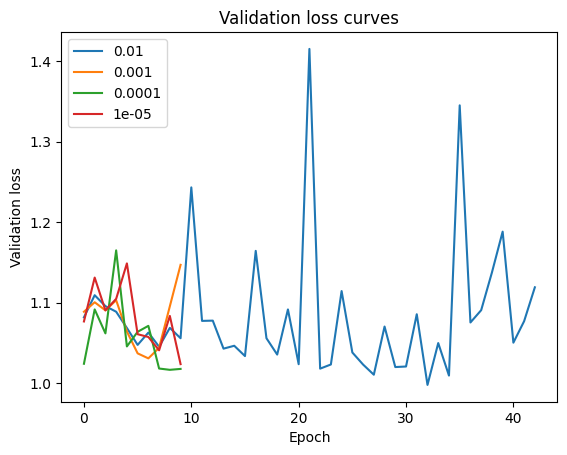

In [73]:
# plot the validation loss curves for each learning rate
for h in histories_v1:
    plt.plot(h.history['val_loss'])
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss curves')

Text(0.5, 1.0, 'Validation accuracy curves')

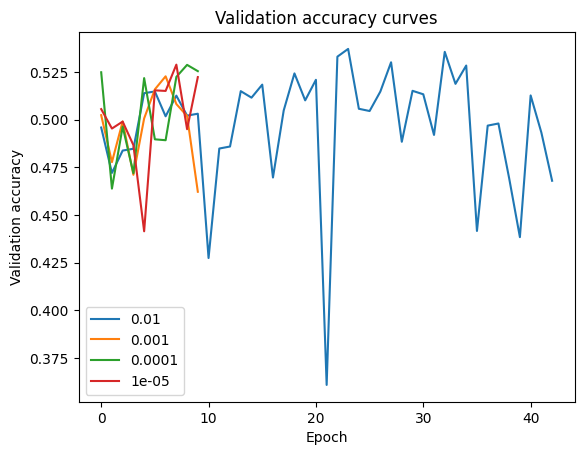

In [74]:
# plot the validation accuracy curves for each learning rate
for h in histories_v1:
    plt.plot(h.history['val_accuracy'])
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy curves')

The model achieved a worse accuracy than the standard models, and its learning curves behave irregularily, which could mean overfitting. The next iteration will include dropout layer to try and fight it.

### Second iteration

In [75]:
# Build the deep learning model
deep_model2 = Sequential()
deep_model2.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
deep_model2.add(Dropout(0.5))  
deep_model2.add(Dense(8, activation='relu'))
deep_model2.add(Dropout(0.5))  
deep_model2.add(Dense(4, activation='softmax'))  
deep_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [76]:
# create a function for training the model
def train_model_v2(learning_rates):
    histories = []
    models = []
    best_val_losses = []
    for lr in learning_rates:
        print(f"Training model with learning rate = {lr}")
        model = deep_model2
        history = model.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])
        histories.append(history)
        best_val_losses.append(min(history.history['val_loss']))
        models.append(model)
    
    # get the index of the best model
    best_model_index = np.argmin(best_val_losses)
    # get the best model
    best_model = models[best_model_index]
            
    return histories, best_val_losses, best_model

In [77]:
# Train the model with different learning rates
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
histories_v2, best_val_losses_v2, best_model_v2 = train_model_v2(learning_rates)
best_model_v2.summary()

Training model with learning rate = 0.01
Epoch 1/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3006 - loss: 53.6243 - val_accuracy: 0.4343 - val_loss: 1.1151
Epoch 2/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3933 - loss: 1.3997 - val_accuracy: 0.4531 - val_loss: 1.1679
Epoch 3/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step - accuracy: 0.3761 - loss: 1.2390 - val_accuracy: 0.4643 - val_loss: 1.1521
Epoch 4/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.3862 - loss: 1.2258 - val_accuracy: 0.4761 - val_loss: 1.1209
Epoch 5/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - accuracy: 0.3974 - loss: 1.2041 - val_accuracy: 0.5028 - val_loss: 1.0801
Epoch 6/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.4110 - loss: 1.1797 - val_accuracy: 0.5099 - val_loss: 1.0633
Epoch 7/50
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4162 - loss: 1.1679 - val_accuracy: 0.4938 - val_loss: 1.0819
Epoch 8/50
2124/2124 ━━━━━━━━━━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 12)             │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638 (2.50 KB)

 Trainable params: 212 (848.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 426 (1.67 KB)

In [82]:
# get validation accuracy
scores = best_model_v2.evaluate(X_test, y_test_encoded, verbose=1)
print("%s: %.2f%%" % (best_model_v2.metrics_names[1], scores[1]*100))

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5216 - loss: 1.0415
compile_metrics: 51.67%


In [83]:
# make predictions
y_pred = best_model_v2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class labels

# If y_test is one-hot encoded, convert it to class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes))

531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step
              precision    recall  f1-score   support

           0       0.46      0.43      0.44      4609
           1       0.61      0.15      0.24      3572
           2       0.38      0.80      0.51      4051
           3       0.95      0.64      0.76      4757

    accuracy                           0.52     16989
   macro avg       0.60      0.50      0.49     16989
weighted avg       0.61      0.52      0.51     16989



Text(0.5, 1.0, 'Validation loss curves')

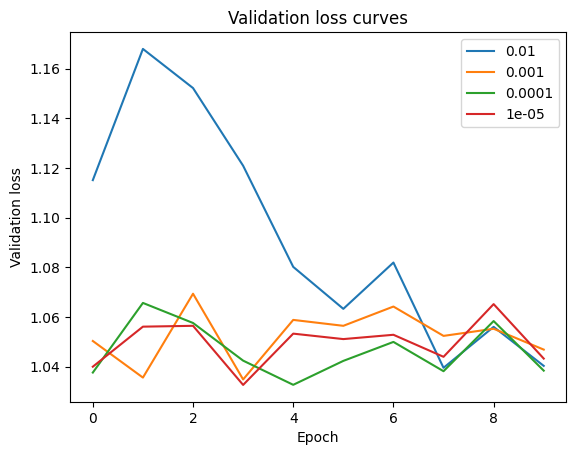

In [84]:
# plot the validation loss curves for each learning rate
for h in histories_v2:
    plt.plot(h.history['val_loss'])
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss curves')

Text(0.5, 1.0, 'Validation accuracy curves')

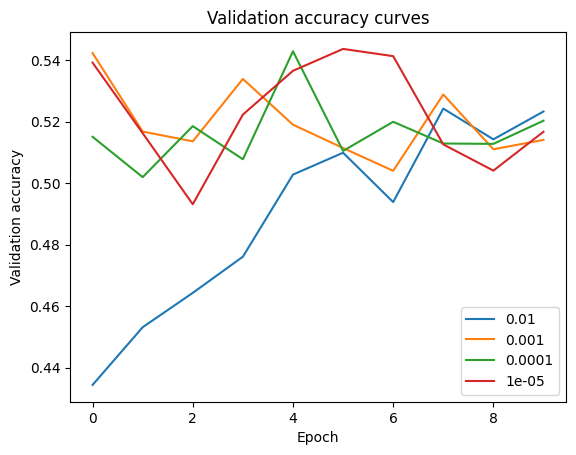

In [81]:
# plot the validation accuracy curves for each learning rate
for h in histories_v2:
    plt.plot(h.history['val_accuracy'])
plt.legend(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy curves')

### Comparison with classical models

The second model performs slightly better, and features smoother curves, which likely means that the model overfits less. However, it still performs worse than the classical models and is much more resource-intensive, which means we will not be using it in our application.